In [16]:
# import libraries
import numpy as np
import pandas as pd
import swat as sw
import os
#os.environ['CUDA_VISIBLE_DEVICES']='1'
os.environ['CUDA_VISIBLE_DEVICES']='0'
import warnings
warnings.filterwarnings("ignore")

In [2]:
cov_data = pd.read_csv('../gan-testing/data/covertype.csv')
cov_discrete_columns = "v11,v12,v13,v14,v15,v16,v17,v18,v19,v20,v21,v22,v23,v24,v25,v26,v27,v28,v29,v30,v31,v32,v33,v34,v35,v36,v37,v38,v39,v40,v41,v42,v43,v44,v45,v46,v47,v48,v49,v50,v51,v52,v53,v54,label".split(',')

In [3]:
cov_data

,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,...,v46,v47,v48,v49,v50,v51,v52,v53,v54,label
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581007,2396,153,20,85,17,108,240,237,118,837,...,0,0,0,0,0,0,0,0,0,3
581008,2391,152,19,67,12,95,240,237,119,845,...,0,0,0,0,0,0,0,0,0,3
581009,2386,159,17,60,7,90,236,241,130,854,...,0,0,0,0,0,0,0,0,0,3
581010,2384,170,15,60,5,90,230,245,143,864,...,0,0,0,0,0,0,0,0,0,3


In [18]:
cov_numeric_columns = [x for x in cov_data.columns if x not in cov_discrete_columns]
cov_numeric_columns

['v1', 'v2', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8', 'v9', 'v10']

In [4]:
# pick only two labels for binary classification
cov_data = cov_data[cov_data.label <=2]##binary classification
df=cov_data.loc[:,'label']
df.value_counts()

2    283301
1    211840
Name: label, dtype: int64

In [5]:
def stratified_sample_df(df, col, n_samples):
    n = min(n_samples, df[col].value_counts().min())
    df_ = df.groupby(col).apply(lambda x: x.sample(n))
    df_.index = df_.index.droplevel(0)
    return df_

cov_data_sampled = stratified_sample_df(cov_data, 'label', 25000)

In [6]:
df=cov_data_sampled.loc[:,'label']
df.value_counts()

2    25000
1    25000
Name: label, dtype: int64

In [7]:
cov_X = cov_data_sampled.drop(["label"],axis=1)
orig_X, orig_y = cov_X,cov_data_sampled.loc[:,"label"]
print(orig_y.value_counts())

2    25000
1    25000
Name: label, dtype: int64


In [8]:
from sklearn.model_selection import train_test_split

orig_X_train, orig_X_test, orig_y_train, orig_y_test = train_test_split(orig_X, orig_y, test_size=0.3, random_state=123)
my_data1_train = pd.concat([orig_X_train,orig_y_train],axis=1)
my_data1_test = pd.concat([orig_X_test,orig_y_test],axis=1)
#my_data1_test.describe()
orig_y_train = orig_y_train.astype('int')
orig_y_test = orig_y_test.astype('int')

In [9]:
# train ML models on the train set of the original data
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
names = ["Decision Tree","Linear SVM", "Random Forest", "Logistic Regression","MLP"]

classifiers = [
    DecisionTreeClassifier(max_depth=5,random_state=0),
    SVC(kernel = 'linear', max_iter=1000, C=0.025, random_state=0, probability=True),
    RandomForestClassifier(n_estimators=200, random_state=0),
    LogisticRegression(max_iter=1000, random_state=0),
    MLPClassifier(alpha=1, max_iter=1000, random_state=0)]

In [10]:
print('ML scores for the original data:')
for name, clf in zip(names, classifiers):
    clf.fit(orig_X_train, orig_y_train)
    score = clf.score(orig_X_test, orig_y_test)
    y_pred = clf.predict(orig_X_test)
    Acc = accuracy_score(orig_y_test, y_pred)
    fscore = f1_score(orig_y_test, y_pred, average='binary')
    AUC = roc_auc_score(orig_y_test, clf.predict_proba(orig_X_test)[:, 1])
    print(name,'Acc: ', Acc, 'f-1: ', fscore, 'AUC:', AUC)


ML scores for the original data:
Decision Tree Acc:  0.7616 f-1:  0.7622656561627443 AUC: 0.8335347270362052
Linear SVM Acc:  0.4634 f-1:  0.5254407169388597 AUC: 0.4473331177870317
Random Forest Acc:  0.8948 f-1:  0.8925799863852961 AUC: 0.9631996006708671
Logistic Regression Acc:  0.7638666666666667 f-1:  0.7625368731563422 AUC: 0.8405767459921754
MLP Acc:  0.567 f-1:  0.23145189918352857 AUC: 0.757500932159804


In [11]:
# # now input the data to CPCTGAN and train
# cov_discrete_columns = cov_discrete_columns[:-1]
cov_discrete_columns

['v11',
 'v12',
 'v13',
 'v14',
 'v15',
 'v16',
 'v17',
 'v18',
 'v19',
 'v20',
 'v21',
 'v22',
 'v23',
 'v24',
 'v25',
 'v26',
 'v27',
 'v28',
 'v29',
 'v30',
 'v31',
 'v32',
 'v33',
 'v34',
 'v35',
 'v36',
 'v37',
 'v38',
 'v39',
 'v40',
 'v41',
 'v42',
 'v43',
 'v44',
 'v45',
 'v46',
 'v47',
 'v48',
 'v49',
 'v50',
 'v51',
 'v52',
 'v53',
 'v54',
 'label']

In [12]:
# get the train data for gan with same seed as the ML utility
GAN_X = cov_data_sampled.drop(["label"],axis=1)
GAN_orig_X, GAN_orig_y = GAN_X,cov_data_sampled.loc[:,"label"]

In [13]:
from sklearn.model_selection import train_test_split

GAN_X_train, GAN_X_test, GAN_y_train, GAN_y_test = train_test_split(GAN_orig_X, GAN_orig_y, test_size=0.3, random_state=123)
GAN_data_train = pd.concat([GAN_X_train,GAN_y_train],axis=1)
GAN_data_test = pd.concat([GAN_X_test,GAN_y_test],axis=1)
#my_data1_test.describe()

In [19]:
s = sw.CAS('dl2073.clstr.rnd.sas.com',33789)

In [20]:
s.loadactionset('generativeAdversarialNet')

NOTE: Added action set 'generativeAdversarialNet'.


[actionset]

 'generativeAdversarialNet'

+ Elapsed: 0.352s, user: 3.36s, sys: 2.86s, mem: 0.222mb

In [21]:
s.upload(GAN_data_train, casout=dict(name='GAN_data_train', replace=True))

NOTE: Cloud Analytic Services made the uploaded file available as table GAN_DATA_TRAIN in caslib CASUSER(alphel).
NOTE: The table GAN_DATA_TRAIN has been created in caslib CASUSER(alphel) from binary data uploaded to Cloud Analytic Services.


[caslib]

 'CASUSER(alphel)'

[tableName]

 'GAN_DATA_TRAIN'

[casTable]

 CASTable('GAN_DATA_TRAIN', caslib='CASUSER(alphel)')

+ Elapsed: 0.161s, user: 0.281s, sys: 0.0886s, mem: 80.3mb

In [22]:
cen = pd.read_csv("../gan-testing/data/covertype_centroids.csv")
s.upload(cen, casout=dict(name='cen', replace=True))
cen

NOTE: Cloud Analytic Services made the uploaded file available as table CEN in caslib CASUSER(alphel).
NOTE: The table CEN has been created in caslib CASUSER(alphel) from binary data uploaded to Cloud Analytic Services.


,VarName,Centroid_i,weight,Mean,Std
0,v10,1,0.16094,1876.13,765.03
1,v10,2,0.15416,1625.05,718.52
2,v10,3,0.22085,910.25,414.09
3,v10,4,0.15237,2396.76,673.61
4,v10,5,0.15592,1468.69,672.13
...,...,...,...,...,...
59,v8,6,0.13265,216.85,15.12
60,v8,7,0.17448,238.29,9.43
61,v9,1,0.36185,146.95,33.01
62,v9,2,0.30082,118.90,47.51


In [23]:
results = s.tabularGanTrain(
table = {"name":"GAN_data_train"},
    centroidsTable= "cen",
    gpu = 1,
    nominals = cov_discrete_columns,
    optimizerAe ={"method":'ADAM',"numEpochs":500},
    optimizerGan ={"method":'ADAM',"numEpochs":500},
    seed = 12345,
    scoreSeed = 1234,
    numSamples =50000,
    saveState ={"name":"cpctStore", "replace":True},
    casOut = {"name":"out", "replace":True}
)
results

NOTE: Using device: GPU 0.
NOTE: Epoch i=1, ae_loss=  0.1302.
NOTE: Epoch i=2, ae_loss=  0.1174.
NOTE: Epoch i=3, ae_loss=  0.1093.
NOTE: Epoch i=4, ae_loss=  0.1061.
NOTE: Epoch i=5, ae_loss=  0.0944.
NOTE: Epoch i=6, ae_loss=  0.0555.
NOTE: Epoch i=7, ae_loss=  0.0505.
NOTE: Epoch i=8, ae_loss=  0.0452.
NOTE: Epoch i=9, ae_loss=  0.0437.
NOTE: Epoch i=10, ae_loss=  0.0419.
NOTE: Epoch i=11, ae_loss=  0.0408.
NOTE: Epoch i=12, ae_loss=  0.0408.
NOTE: Epoch i=13, ae_loss=  0.0374.
NOTE: Epoch i=14, ae_loss=  0.0361.
NOTE: Epoch i=15, ae_loss=  0.0368.
NOTE: Epoch i=16, ae_loss=  0.0343.
NOTE: Epoch i=17, ae_loss=  0.0325.
NOTE: Epoch i=18, ae_loss=  0.0319.
NOTE: Epoch i=19, ae_loss=  0.0312.
NOTE: Epoch i=20, ae_loss=  0.0310.
NOTE: Epoch i=21, ae_loss=  0.0306.
NOTE: Epoch i=22, ae_loss=  0.0304.
NOTE: Epoch i=23, ae_loss=  0.0289.
NOTE: Epoch i=24, ae_loss=  0.0274.
NOTE: Epoch i=25, ae_loss=  0.0277.
NOTE: Epoch i=26, ae_loss=  0.0271.
NOTE: Epoch i=27, ae_loss=  0.0264.
NOTE: Epoc

NOTE: Epoch i=226, ae_loss=  0.0130.
NOTE: Epoch i=227, ae_loss=  0.0132.
NOTE: Epoch i=228, ae_loss=  0.0136.
NOTE: Epoch i=229, ae_loss=  0.0141.
NOTE: Epoch i=230, ae_loss=  0.0139.
NOTE: Epoch i=231, ae_loss=  0.0135.
NOTE: Epoch i=232, ae_loss=  0.0133.
NOTE: Epoch i=233, ae_loss=  0.0131.
NOTE: Epoch i=234, ae_loss=  0.0142.
NOTE: Epoch i=235, ae_loss=  0.0140.
NOTE: Epoch i=236, ae_loss=  0.0136.
NOTE: Epoch i=237, ae_loss=  0.0142.
NOTE: Epoch i=238, ae_loss=  0.0136.
NOTE: Epoch i=239, ae_loss=  0.0139.
NOTE: Epoch i=240, ae_loss=  0.0142.
NOTE: Epoch i=241, ae_loss=  0.0133.
NOTE: Epoch i=242, ae_loss=  0.0134.
NOTE: Epoch i=243, ae_loss=  0.0137.
NOTE: Epoch i=244, ae_loss=  0.0133.
NOTE: Epoch i=245, ae_loss=  0.0139.
NOTE: Epoch i=246, ae_loss=  0.0121.
NOTE: Epoch i=247, ae_loss=  0.0131.
NOTE: Epoch i=248, ae_loss=  0.0123.
NOTE: Epoch i=249, ae_loss=  0.0130.
NOTE: Epoch i=250, ae_loss=  0.0131.
NOTE: Epoch i=251, ae_loss=  0.0135.
NOTE: Epoch i=252, ae_loss=  0.0138.
N

NOTE: Epoch i=449, ae_loss=  0.0121.
NOTE: Epoch i=450, ae_loss=  0.0118.
NOTE: Epoch i=451, ae_loss=  0.0136.
NOTE: Epoch i=452, ae_loss=  0.0119.
NOTE: Epoch i=453, ae_loss=  0.0129.
NOTE: Epoch i=454, ae_loss=  0.0129.
NOTE: Epoch i=455, ae_loss=  0.0129.
NOTE: Epoch i=456, ae_loss=  0.0124.
NOTE: Epoch i=457, ae_loss=  0.0128.
NOTE: Epoch i=458, ae_loss=  0.0129.
NOTE: Epoch i=459, ae_loss=  0.0128.
NOTE: Epoch i=460, ae_loss=  0.0122.
NOTE: Epoch i=461, ae_loss=  0.0131.
NOTE: Epoch i=462, ae_loss=  0.0128.
NOTE: Epoch i=463, ae_loss=  0.0136.
NOTE: Epoch i=464, ae_loss=  0.0124.
NOTE: Epoch i=465, ae_loss=  0.0126.
NOTE: Epoch i=466, ae_loss=  0.0126.
NOTE: Epoch i=467, ae_loss=  0.0132.
NOTE: Epoch i=468, ae_loss=  0.0132.
NOTE: Epoch i=469, ae_loss=  0.0119.
NOTE: Epoch i=470, ae_loss=  0.0129.
NOTE: Epoch i=471, ae_loss=  0.0128.
NOTE: Epoch i=472, ae_loss=  0.0120.
NOTE: Epoch i=473, ae_loss=  0.0135.
NOTE: Epoch i=474, ae_loss=  0.0134.
NOTE: Epoch i=475, ae_loss=  0.0130.
N

NOTE: Epoch i=125, g_loss= -7.2427, d_loss=  0.1543.
NOTE: Epoch i=126, g_loss= -7.1909, d_loss= -0.1987.
NOTE: Epoch i=127, g_loss= -7.1065, d_loss=  0.3087.
NOTE: Epoch i=128, g_loss= -7.1645, d_loss= -0.0488.
NOTE: Epoch i=129, g_loss= -6.8826, d_loss= -0.1139.
NOTE: Epoch i=130, g_loss= -6.9007, d_loss= -0.2998.
NOTE: Epoch i=131, g_loss= -7.2684, d_loss=  0.2414.
NOTE: Epoch i=132, g_loss= -6.7873, d_loss=  0.0993.
NOTE: Epoch i=133, g_loss= -6.7639, d_loss= -0.6805.
NOTE: Epoch i=134, g_loss= -6.5789, d_loss= -0.0896.
NOTE: Epoch i=135, g_loss= -6.6832, d_loss=  0.2948.
NOTE: Epoch i=136, g_loss= -6.5546, d_loss=  0.1349.
NOTE: Epoch i=137, g_loss= -6.4751, d_loss= -0.0637.
NOTE: Epoch i=138, g_loss= -6.6585, d_loss= -0.0310.
NOTE: Epoch i=139, g_loss= -6.4088, d_loss=  0.1335.
NOTE: Epoch i=140, g_loss= -6.0700, d_loss= -0.0367.
NOTE: Epoch i=141, g_loss= -6.4670, d_loss= -0.0906.
NOTE: Epoch i=142, g_loss= -6.4519, d_loss=  0.2411.
NOTE: Epoch i=143, g_loss= -6.3458, d_loss=  0

NOTE: Epoch i=281, g_loss= -1.8550, d_loss= -0.8134.
NOTE: Epoch i=282, g_loss= -1.9044, d_loss= -0.5647.
NOTE: Epoch i=283, g_loss= -1.8367, d_loss=  0.3780.
NOTE: Epoch i=284, g_loss= -1.9489, d_loss=  0.0779.
NOTE: Epoch i=285, g_loss= -1.5419, d_loss=  0.3410.
NOTE: Epoch i=286, g_loss= -1.7877, d_loss= -0.5972.
NOTE: Epoch i=287, g_loss= -1.2894, d_loss=  0.6042.
NOTE: Epoch i=288, g_loss= -1.8879, d_loss= -0.2084.
NOTE: Epoch i=289, g_loss= -1.4370, d_loss= -0.0347.
NOTE: Epoch i=290, g_loss= -1.3217, d_loss=  0.2681.
NOTE: Epoch i=291, g_loss= -1.0621, d_loss= -0.5695.
NOTE: Epoch i=292, g_loss= -1.0930, d_loss= -0.6217.
NOTE: Epoch i=293, g_loss= -0.7692, d_loss= -0.1205.
NOTE: Epoch i=294, g_loss= -0.7933, d_loss= -0.6144.
NOTE: Epoch i=295, g_loss= -0.8296, d_loss=  0.0489.
NOTE: Epoch i=296, g_loss= -0.6912, d_loss=  0.4603.
NOTE: Epoch i=297, g_loss= -0.4174, d_loss=  0.6039.
NOTE: Epoch i=298, g_loss= -0.8419, d_loss= -0.4798.
NOTE: Epoch i=299, g_loss= -1.0092, d_loss= -0

NOTE: Epoch i=436, g_loss=  1.0911, d_loss=  0.2849.
NOTE: Epoch i=437, g_loss=  1.0472, d_loss= -0.3053.
NOTE: Epoch i=438, g_loss=  0.4914, d_loss= -0.0174.
NOTE: Epoch i=439, g_loss=  1.0914, d_loss=  0.1315.
NOTE: Epoch i=440, g_loss=  0.5566, d_loss= -0.1650.
NOTE: Epoch i=441, g_loss=  0.3810, d_loss= -0.0622.
NOTE: Epoch i=442, g_loss= -0.2789, d_loss= -0.1495.
NOTE: Epoch i=443, g_loss=  0.7169, d_loss=  0.0248.
NOTE: Epoch i=444, g_loss=  0.5074, d_loss=  0.6921.
NOTE: Epoch i=445, g_loss=  0.4092, d_loss= -0.3402.
NOTE: Epoch i=446, g_loss=  1.1709, d_loss= -0.0731.
NOTE: Epoch i=447, g_loss=  0.7311, d_loss= -0.1302.
NOTE: Epoch i=448, g_loss=  0.4982, d_loss=  0.8197.
NOTE: Epoch i=449, g_loss=  1.1752, d_loss= -0.9691.
NOTE: Epoch i=450, g_loss=  1.0008, d_loss=  0.3933.
NOTE: Epoch i=451, g_loss=  1.2021, d_loss= -0.1222.
NOTE: Epoch i=452, g_loss=  1.1509, d_loss=  0.3824.
NOTE: Epoch i=453, g_loss=  0.7552, d_loss= -0.0188.
NOTE: Epoch i=454, g_loss=  0.8294, d_loss= -0

,EpochNumber,AutoencoderLoss,GeneratorLoss,DiscriminatorLoss
0,1,0.130240,NaN,NaN
1,2,0.117382,NaN,NaN
2,3,0.109262,NaN,NaN
3,4,0.106114,NaN,NaN
4,5,0.094419,NaN,NaN
...,...,...,...,...
995,496,NaN,1.207158,0.161225
996,497,NaN,1.099795,-0.395746
997,498,NaN,0.773278,-0.398004
998,499,NaN,0.970907,-0.063536


In [24]:
samples = s.fetch('out', to=400000, maxrows=400000)['Fetch']
gloss = results.IterHistory['GeneratorLoss'].dropna().reset_index(drop=True)
dloss = results.IterHistory['DiscriminatorLoss'].dropna().reset_index(drop=True)

Text(0.5, 1.0, 'Losses for CPCTGAN on CoverType data')

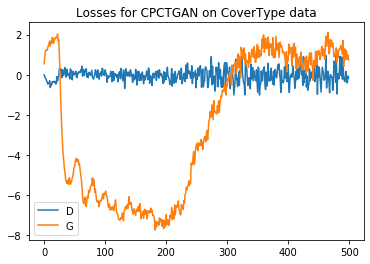

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure()
plt.plot(dloss)
plt.plot(gloss)
plt.legend(['D', 'G'])
plt.title('Losses for CPCTGAN on CoverType data')
#plt.savefig('Original-CTGAN-Adult')

In [26]:
samples['label'].value_counts()

1.0    25941
2.0    24059
Name: label, dtype: int64

In [27]:
#adult_data_all.head()
fake_X = samples.drop(["label"],axis=1)
fake_X, fake_y = fake_X,samples.loc[:,"label"]

In [28]:
# check the training data shape to agree with the original data (# of features/cols)
print(fake_X.shape)
print(fake_y.shape)
print(orig_X_test.shape)

(50000, 54)
(50000,)
(15000, 54)


In [29]:
# train a classifier on the CPCTGAN generated data
classifiers = [
    DecisionTreeClassifier(max_depth=5,random_state=0),
    SVC(kernel = 'linear', max_iter=1000, C=0.025, random_state=0, probability=True),
    RandomForestClassifier(n_estimators=200, random_state=0),
    LogisticRegression(max_iter=1000, random_state=0),
    MLPClassifier(alpha=1, max_iter=1000, random_state=0)]

print('ML scores for the GAN generated data:')
for name, clf in zip(names, classifiers):
    clf.fit(fake_X, fake_y)
    score = clf.score(orig_X_test, orig_y_test)
    y_pred = clf.predict(orig_X_test)
    Acc = accuracy_score(orig_y_test, y_pred)
    fscore = f1_score(orig_y_test, y_pred, average='binary')
    AUC = roc_auc_score(orig_y_test, clf.predict_proba(orig_X_test)[:, 1])
    print(name,'Acc: ', Acc, 'f-1: ', fscore, 'AUC:', AUC)

ML scores for the GAN generated data:
Decision Tree Acc:  0.7464666666666666 f-1:  0.7590750712701932 AUC: 0.8128868116410866
Linear SVM Acc:  0.4693333333333333 f-1:  0.5012531328320802 AUC: 0.4663782358153482
Random Forest Acc:  0.7560666666666667 f-1:  0.7613955004890773 AUC: 0.8280339660946889
Logistic Regression Acc:  0.7218666666666667 f-1:  0.7225694906237532 AUC: 0.7924872232265183
MLP Acc:  0.6744666666666667 f-1:  0.6264820622657387 AUC: 0.726017893875996


In [30]:
fake_y.value_counts()

1.0    25941
2.0    24059
Name: label, dtype: int64

In [31]:
orig_y_test.value_counts()

2    7633
1    7367
Name: label, dtype: int64

In [32]:
sum(y_pred)/len(y_pred)

1.6196

### train CTGAN on same data

In [33]:
from ctgan import CTGANSynthesizer

In [34]:
# train CTGAN and generate fake data
ctgan = CTGANSynthesizer(verbose=True)
ctgan.fit(GAN_data_train, cov_discrete_columns, epochs=500)

Epoch 1, Loss G: -2.6864,Loss D: -0.6043
Epoch 2, Loss G: -2.2125,Loss D:  0.3068
Epoch 3, Loss G: -1.9280,Loss D: -0.1577
Epoch 4, Loss G: -2.5762,Loss D: -0.2678
Epoch 5, Loss G: -1.6353,Loss D: -0.6591
Epoch 6, Loss G: -2.3421,Loss D:  0.1088
Epoch 7, Loss G: -2.8534,Loss D:  0.3613
Epoch 8, Loss G: -2.6113,Loss D: -0.4859
Epoch 9, Loss G: -2.0300,Loss D:  0.6054
Epoch 10, Loss G: -2.6107,Loss D: -0.1271
Epoch 11, Loss G: -2.4115,Loss D: -0.5965
Epoch 12, Loss G: -2.3249,Loss D:  0.3018
Epoch 13, Loss G: -2.9022,Loss D: -0.2775
Epoch 14, Loss G: -3.7291,Loss D: -0.0367
Epoch 15, Loss G: -3.8095,Loss D: -0.5686
Epoch 16, Loss G: -3.8778,Loss D:  0.7235
Epoch 17, Loss G: -3.4199,Loss D: -0.0667
Epoch 18, Loss G: -3.4569,Loss D:  0.5409
Epoch 19, Loss G: -4.0054,Loss D: -1.0383
Epoch 20, Loss G: -4.0684,Loss D:  0.0706
Epoch 21, Loss G: -4.7258,Loss D: -0.4553
Epoch 22, Loss G: -4.4477,Loss D:  0.4417
Epoch 23, Loss G: -4.1633,Loss D: -1.0142
Epoch 24, Loss G: -4.2719,Loss D:  0.3893
E

Epoch 195, Loss G: -4.7568,Loss D: -0.0216
Epoch 196, Loss G: -4.1681,Loss D:  0.7411
Epoch 197, Loss G: -5.0201,Loss D:  0.0128
Epoch 198, Loss G: -4.6964,Loss D:  0.1426
Epoch 199, Loss G: -4.8464,Loss D:  0.3853
Epoch 200, Loss G: -4.3099,Loss D:  0.2007
Epoch 201, Loss G: -4.8220,Loss D:  0.0864
Epoch 202, Loss G: -4.8249,Loss D:  0.1962
Epoch 203, Loss G: -4.4208,Loss D:  0.0648
Epoch 204, Loss G: -4.7018,Loss D: -0.1891
Epoch 205, Loss G: -4.1471,Loss D: -0.1514
Epoch 206, Loss G: -4.9994,Loss D:  0.2838
Epoch 207, Loss G: -4.5416,Loss D: -0.1442
Epoch 208, Loss G: -4.9797,Loss D: -0.5117
Epoch 209, Loss G: -4.2278,Loss D:  0.2811
Epoch 210, Loss G: -4.5277,Loss D:  0.0193
Epoch 211, Loss G: -4.5482,Loss D:  0.3245
Epoch 212, Loss G: -4.7757,Loss D: -0.4299
Epoch 213, Loss G: -4.3209,Loss D: -0.2114
Epoch 214, Loss G: -4.4885,Loss D: -0.2511
Epoch 215, Loss G: -4.4451,Loss D:  0.4003
Epoch 216, Loss G: -4.6960,Loss D: -0.0841
Epoch 217, Loss G: -4.8026,Loss D: -0.6823
Epoch 218, 

Epoch 386, Loss G: -3.9070,Loss D: -0.0876
Epoch 387, Loss G: -3.9035,Loss D:  0.1134
Epoch 388, Loss G: -3.3552,Loss D:  0.3330
Epoch 389, Loss G: -3.6454,Loss D: -0.2314
Epoch 390, Loss G: -3.8350,Loss D:  0.0536
Epoch 391, Loss G: -4.0059,Loss D: -0.1647
Epoch 392, Loss G: -3.9435,Loss D: -0.0761
Epoch 393, Loss G: -3.8561,Loss D: -0.1877
Epoch 394, Loss G: -3.5094,Loss D: -0.0549
Epoch 395, Loss G: -3.9113,Loss D: -0.0693
Epoch 396, Loss G: -3.7533,Loss D: -0.1191
Epoch 397, Loss G: -3.8842,Loss D: -0.0239
Epoch 398, Loss G: -3.6971,Loss D: -0.3002
Epoch 399, Loss G: -4.2434,Loss D: -0.2540
Epoch 400, Loss G: -3.6849,Loss D:  0.1540
Epoch 401, Loss G: -3.8089,Loss D:  0.0804
Epoch 402, Loss G: -3.7646,Loss D: -0.0808
Epoch 403, Loss G: -3.4526,Loss D:  0.1484
Epoch 404, Loss G: -3.6785,Loss D: -0.0548
Epoch 405, Loss G: -3.4562,Loss D:  0.0338
Epoch 406, Loss G: -3.5046,Loss D:  0.0433
Epoch 407, Loss G: -3.6302,Loss D: -0.2957
Epoch 408, Loss G: -3.8834,Loss D:  0.1779
Epoch 409, 

In [35]:
# create fake samples
samples = ctgan.sample(50000)
samples['label'].value_counts()

2    33311
1    16689
Name: label, dtype: int64

In [36]:
#adult_data_all.head()
fake_X = samples.drop(["label"],axis=1)
fake_X, fake_y = fake_X,samples.loc[:,"label"]

In [37]:
# check the training data shape to agree with the original data (# of features/cols)
print(fake_X.shape)
print(fake_y.shape)
print(orig_X_test.shape)

(50000, 54)
(50000,)
(15000, 54)


In [38]:
# train a classifier on the CTGAN generated data
classifiers = [
    DecisionTreeClassifier(max_depth=5,random_state=0),
    SVC(kernel = 'linear', max_iter=1000, C=0.025, random_state=0, probability=True),
    RandomForestClassifier(n_estimators=200, random_state=0),
    LogisticRegression(max_iter=1000, random_state=0),
    MLPClassifier(alpha=1, max_iter=1000, random_state=0)]

print('ML scores for the GAN generated data:')
for name, clf in zip(names, classifiers):
    clf.fit(fake_X, fake_y)
    score = clf.score(orig_X_test, orig_y_test)
    y_pred = clf.predict(orig_X_test)
    Acc = accuracy_score(orig_y_test, y_pred)
    fscore = f1_score(orig_y_test, y_pred, average='binary')
    AUC = roc_auc_score(orig_y_test, clf.predict_proba(orig_X_test)[:, 1])
    print(name,'Acc: ', Acc, 'f-1: ', fscore, 'AUC:', AUC)

ML scores for the GAN generated data:
Decision Tree Acc:  0.5123333333333333 f-1:  0.03457832915401874 AUC: 0.7046135806156001
Linear SVM Acc:  0.4600666666666667 f-1:  0.5176008100542021 AUC: 0.5448187253054565
Random Forest Acc:  0.5467333333333333 f-1:  0.20563149900689331 AUC: 0.6983029294314438
Logistic Regression Acc:  0.5231333333333333 f-1:  0.07952644447304079 AUC: 0.6522101501394811
MLP Acc:  0.5107333333333334 f-1:  0.00784101662836285 AUC: 0.5912547680994296
